# IBVP for H-Tail Deflection with Elevator-Induced Forcing

## 1. Governing Equation (IBVP)

$$
EI \frac{\partial^4 u(x,t)}{\partial x^4} + \rho A \frac{\partial^2 u(x,t)}{\partial t^2} + r_e \frac{\partial u(x,t)}{\partial t} = f(x, t)
$$

### Boundary Conditions:

$$
u(0,t) = 0, \quad \frac{\partial u}{\partial x}(0,t) = 0 \quad \text{(clamped root)}
$$

$$
\frac{\partial^2 u}{\partial x^2}(L,t) = 0, \quad \frac{\partial^3 u}{\partial x^3}(L,t) = 0 \quad \text{(free tip)}
$$

### Initial Conditions:

$$
u(x,0) = 0, \quad \frac{\partial u}{\partial t}(x,0) = 0
$$

---

## 2. Aerodynamic Forcing Equation

$$
F_L(t) = \frac{1}{2} \rho_\infty V^2 S_e C_{L_\delta} \cdot \delta_e(t)
$$

---

## 3. Term Definitions

| Symbol              | Meaning                                                                 |
|---------------------|-------------------------------------------------------------------------|
| $u(x,t)$            | Vertical deflection of the H-tail at position $x$, time $t$              |
| $EI$                | Flexural stiffness of the H-tail (Young’s modulus $\times$ moment of inertia) |
| $\rho_s$            | Structural material density (kg/m³)                                     |
| $A$                 | Cross-sectional area of the tail (m²)                                   |
| $\rho_\infty$       | Air density (kg/m³)                                                     |
| $V$                 | Flight speed (m/s)                                                      |
| $S_e$               | Elevator area (m²)                                                      |
| $C_{L_\delta}$      | Elevator lift effectiveness (1/rad)                                     |
| $\delta_e(t)$       | Elevator deflection angle (rad), measured or idealized                  |
| $r_e$             | Damping coefficient   |

## 4. Constant Values Required

| Constant           | Typical Value or Source                                     |
|--------------------|-------------------------------------------------------------|
| $E$                | $\sim 70 \times 10^9$ Pa for carbon fiber (depends on spar material) |
| $I$                | Use $\frac{\pi}{64}(D^4 - d^4)$ per tube or sum for structure |
| $A$                | Cross-section area of spars or combined structure            |
| $\rho_s$           | 1600 kg/m³ for carbon, 300–600 kg/m³ for balsa/plywood      |
| $\rho_\infty$      | 1.225 kg/m³ (sea-level standard)                             |
| $V$                | RC flight speed (e.g., 10–30 m/s)                            |
| $S_e$              | Elevator area (span $\times$ chord)                          |
| $C_{L_\delta}$     | 0.6–0.8 rad$^{-1}$ typical                                   |
| $\delta_e(t)$      | Extracted from footage or defined waveform                  |
| $r_e$             | 100 kg/m ⋅ s   |

In [ ]:
# Approximated linear C_l over alpha graph of S8036

import numpy as np
import matplotlib.pyplot as plt

def Cl_from_alpha(alpha_deg):
    """
    Estimate lift coefficient Cl from angle of attack in degrees,
    based on linear interpolation between known data points.
    """
    m = 0.11
    b = 0.2
    return m * alpha_deg + b

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def alpha_approx(
    max_deflection_deg=30,
    min_deflection_deg=-30,
    frequency_hz=30,
    chord_stab_in=6.0,
    chord_elev_in=3.25,
    t_final=0.1,
    dt=0.0001,
    plot=False
):
    """
    Estimate effective alpha angle of the horizontal stabilizer due to sinusoidal elevator deflection.

    Parameters:
    - max_deflection_deg: Maximum elevator deflection (degrees, positive is down)
    - min_deflection_deg: Minimum elevator deflection (degrees, negative is up)
    - frequency_hz: Oscillation frequency of elevator deflection (Hz)
    - chord_stab_in: Length of fixed horizontal stab (inches)
    - chord_elev_in: Length of elevator portion (inches)
    - t_final: total simulation time (s)
    - dt: time step (s)
    - plot: whether to plot alpha vs. time (default: False)

    Returns:
    - t: time array
    - alpha_eff_deg: effective angle of attack (degrees)
    - elevator_deflection: elevator angle over time (degrees)
    """

    # Convert geometry to SI
    chord_stab = chord_stab_in * 0.0254  # m
    chord_elev = chord_elev_in * 0.0254  # m

    # Time vector
    t = np.arange(0, t_final, dt)

    # Elevator deflection angle over time (in degrees)
    amplitude = (max_deflection_deg - min_deflection_deg) / 2
    mean_angle = (max_deflection_deg + min_deflection_deg) / 2
    elevator_deflection = mean_angle + amplitude * np.sin(2 * np.pi * frequency_hz * t)

    # Convert to radians
    delta_rad = np.deg2rad(elevator_deflection)

    # Compute effective angle from LE of stab to TE of deflected elevator
    elev_x = chord_elev * np.cos(delta_rad)
    elev_y = chord_elev * np.sin(delta_rad)
    alpha_eff_rad = np.arctan2(elev_y, chord_stab + elev_x)

    # Convert result to degrees
    alpha_eff_deg = np.rad2deg(alpha_eff_rad)

    # Optional plot
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t, alpha_eff_deg, label="Alpha (deg)")
        plt.xlabel("Time [s]")
        plt.ylabel("Effective AoA [deg]")
        plt.title("Approximated Effective Alpha of H-Stab from Elevator Motion")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return t, alpha_eff_deg, elevator_deflection

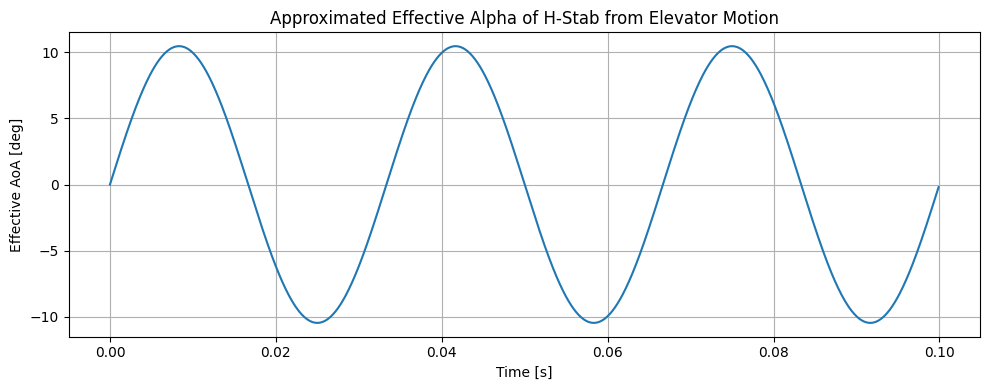

In [ ]:
t, alpha_eff, delta = alpha_approx(
    max_deflection_deg=30,
    min_deflection_deg=-30,
    frequency_hz=30,
    chord_stab_in=6,
    chord_elev_in=3.25,
    t_final=0.1,
    dt=0.0001,
    plot=True
)

In [ ]:
def lift_force(V=90, plot=False, plot_force=False):
    """
    Compute distributed lift force over time and span due to elevator deflection.

    Parameters:
    - V: flight speed in ft/s (converted to m/s)
    - plot: if True, plots Cl(t)
    - plot_force: if True, plots f(t) (distributed force per unit span)

    Returns:
    - f_force: (N, T) array of lift per unit span (N/m)
    - t: time array
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # --- Physical constants and geometry ---
    rho_air = 1.225  # kg/m^3
    chord_hstab_in = 9.25  # inches
    chord_hstab = chord_hstab_in * 0.0254  # meters
    V_mps = V * 0.3048  # convert to m/s

    # Get alpha and time from elevator motion
    t, alpha_eff_deg, _ = alpha_approx(
        max_deflection_deg=30,
        min_deflection_deg=-30,
        frequency_hz=30,
        chord_stab_in=6.0,
        chord_elev_in=3.25,
        t_final=0.1,
        dt=0.0001,
        plot=False
    )

    # Compute Cl over time
    Cl_vals = Cl_from_alpha(alpha_eff_deg)

    # Compute uniform distributed lift per unit span
    L_per_m = 0.5 * rho_air * V_mps**2 * Cl_vals * chord_hstab

    # Construct 2D array (uniform distribution in space)
    N = 101
    f_force = np.tile(L_per_m, (N, 1))  # shape: (N, len(t))

    # Optional: plot lift coefficient
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t, Cl_vals, label="Cl(t)")
        plt.xlabel("Time [s]")
        plt.ylabel("Lift Coefficient Cl")
        plt.title("Lift Coefficient Over Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Optional: plot distributed force at a representative location (e.g. tip)
    if plot_force:
        plt.figure(figsize=(10, 4))
        plt.plot(t, f_force[-1, :], label="Lift Force per Unit Span (N/m)", color='green')
        plt.xlabel("Time [s]")
        plt.ylabel("Lift Force [N/m]")
        plt.title("Distributed Lift Force on H-Stab vs. Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f_force, t

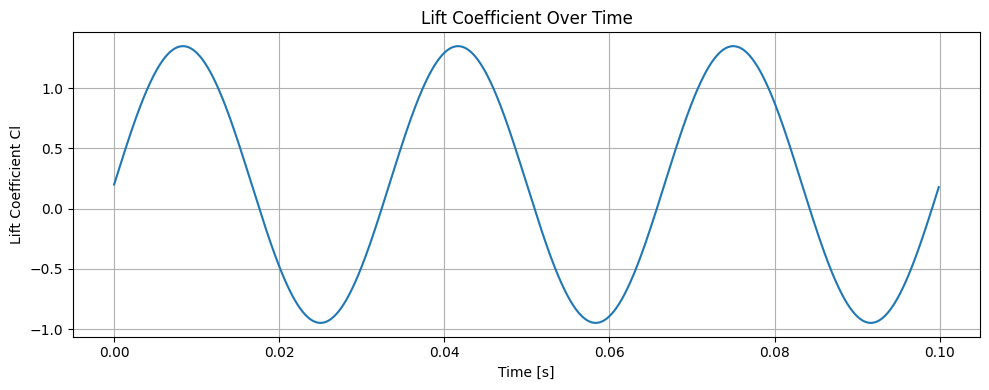

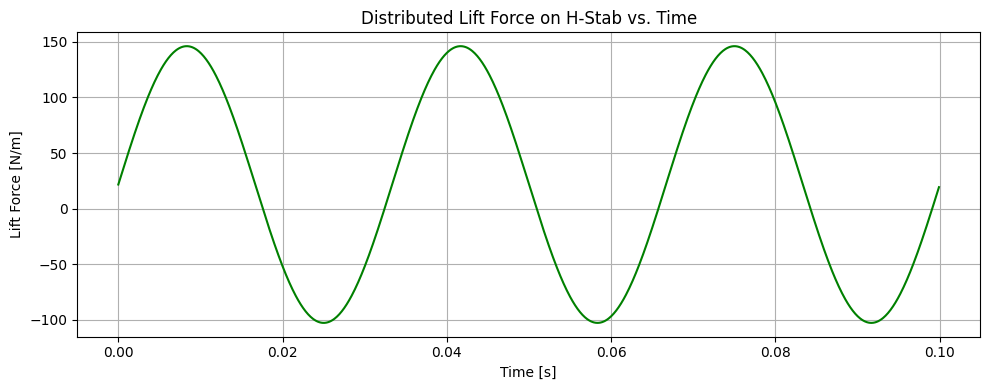

In [ ]:
# Plot both
f_force, t = lift_force(V=90, plot=True, plot_force=True)

<ipython-input-1-10d1dc1a052b>:203: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_next = spsolve(np.eye(N) + r * D4, rhs)


t = 0.0100 s, Lift = 80.265 N/m
t = 0.0200 s, Lift = 129.210 N/m
t = 0.0300 s, Lift = 129.210 N/m
t = 0.0400 s, Lift = 80.265 N/m
t = 0.0500 s, Lift = 0.000 N/m
t = 0.0600 s, Lift = -80.265 N/m
t = 0.0700 s, Lift = -129.210 N/m
t = 0.0800 s, Lift = -129.210 N/m
t = 0.0900 s, Lift = -80.265 N/m
t = 0.1000 s, Lift = -0.000 N/m
t = 0.1100 s, Lift = 80.265 N/m
t = 0.1200 s, Lift = 129.210 N/m
t = 0.1300 s, Lift = 129.210 N/m
t = 0.1400 s, Lift = 80.265 N/m
t = 0.1500 s, Lift = 0.000 N/m
t = 0.1600 s, Lift = -80.265 N/m
t = 0.1700 s, Lift = -129.210 N/m
t = 0.1800 s, Lift = -129.210 N/m
t = 0.1900 s, Lift = -80.265 N/m
t = 0.2000 s, Lift = -0.000 N/m
t = 0.2100 s, Lift = 80.265 N/m
t = 0.2200 s, Lift = 129.210 N/m
t = 0.2300 s, Lift = 129.210 N/m
t = 0.2400 s, Lift = 80.265 N/m
t = 0.2500 s, Lift = 0.000 N/m
t = 0.2600 s, Lift = -80.265 N/m
t = 0.2700 s, Lift = -129.210 N/m
t = 0.2800 s, Lift = -129.210 N/m
t = 0.2900 s, Lift = -80.265 N/m
t = 0.3000 s, Lift = -0.000 N/m
t = 0.3100 s, Lift 

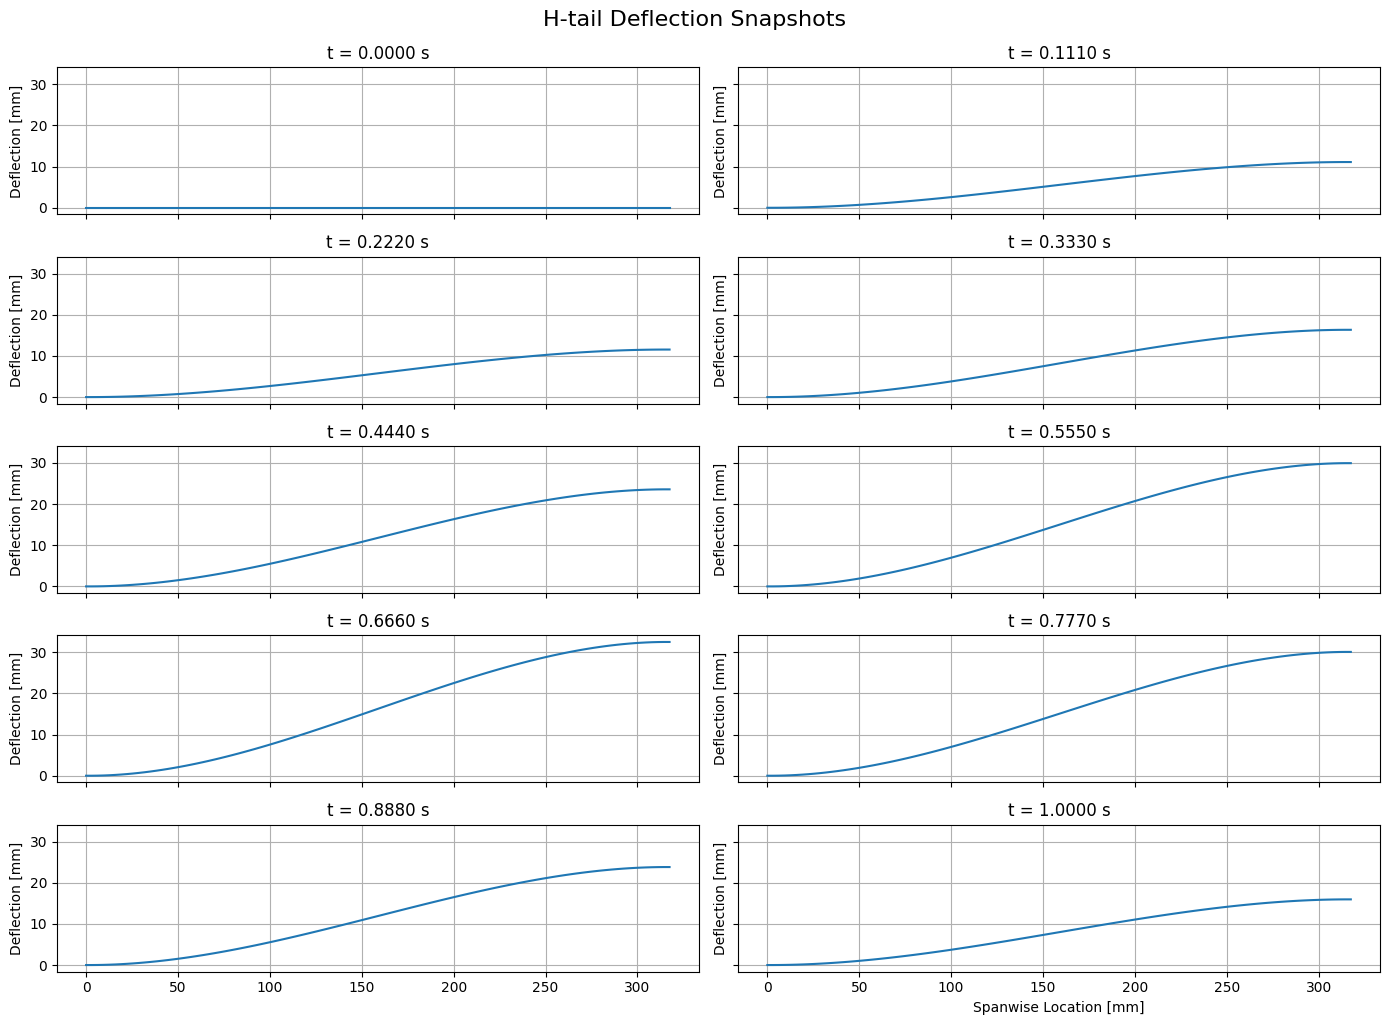

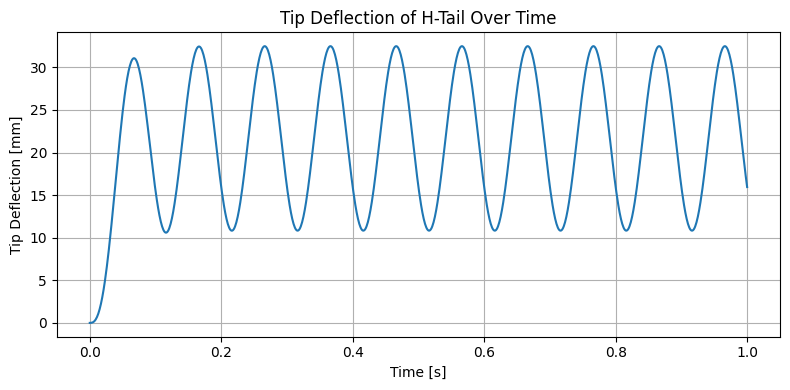

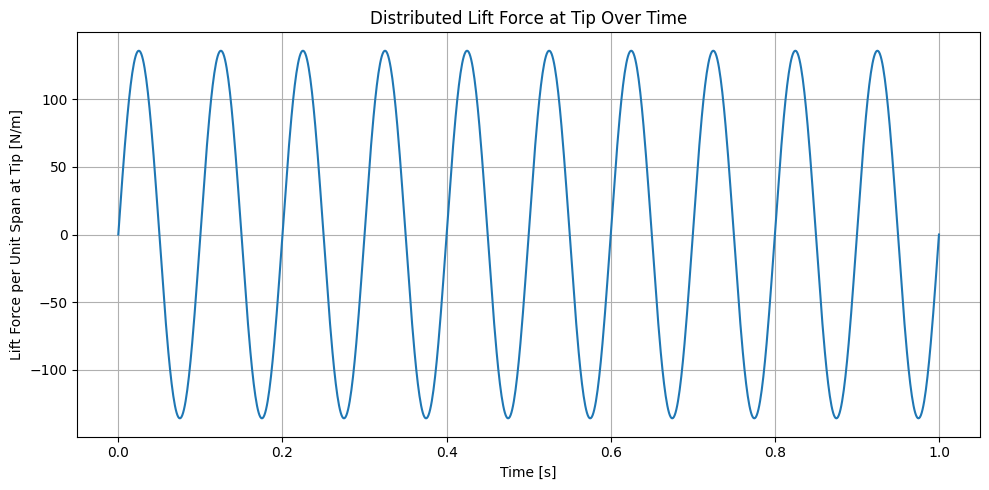

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Geometry (converted from inches to meters) ===
span_in = 12.5               # H-tail span [in]
chord_in = 9.25              # Chord length [in]
thickness_in = chord_in * 0.16          # Airfoil thickness [in]
t_plywood = 0.0937 * 0.0254             # Plywood thickness [m]

# Spar positions (aft of leading edge)
spar1_pos_in = 1.13
spar2_pos_in = 5.55

# Convert to meters
L = span_in * 0.0254
spar1_pos = spar1_pos_in * 0.0254
spar2_pos = spar2_pos_in * 0.0254

# === Spar Dimensions ===
b_spar1 = 12.5 * 0.0254
h_spar1 = 0.9 * 0.0254
b_spar2 = 12.3 * 0.0254
h_spar2 = 0.6 * 0.0254

def hollow_box_I(b, h, t):
    return (b * h**3 - (b - 2*t)*(h - 2*t)**3) / 12

def hollow_box_A(b, h, t):
    return 2 * t * (b + h)

# === Material Properties ===
E = 8e9               # Plywood [Pa]
rho_s = 832           # Plywood [kg/m^3]
E_cf = 500e9          # Carbon Fiber [Pa]
rho_cf = 1930         # Carbon Fiber [kg/m^3]
r_cf = 0.1425 * 0.0254  # Shaft radius [m]


# === Compute Effective Stiffness and Mass ===
# Plywood contribution
I_ply = hollow_box_I(b_spar1, h_spar1, t_plywood) + hollow_box_I(b_spar2, h_spar2, t_plywood)
A_ply = hollow_box_A(b_spar1, h_spar1, t_plywood) + hollow_box_A(b_spar2, h_spar2, t_plywood)

# Carbon fiber shafts
I_cf = 2 * (np.pi * r_cf**4 / 4)
A_cf = 2 * (np.pi * r_cf**2)

# Combined properties
EI_total = E * I_ply + E_cf * I_cf
rhoA_total = rho_s * A_ply + rho_cf * A_cf

# Damping coefficients
re_external = 100       # aerodynamic damping (kg/m·s)

ELEVATOR_FREQ_HZ = 10

# === Simulation Parameters ===
dt = 0.001         # time step (s)
T_final = 1       # simulation duration (s)
N = 101              # spatial points
dx = L / (N - 1)
x = np.linspace(0, L, N)
time_steps = int(T_final / dt) + 1

# === Get aerodynamic forcing from elevator motion ===
def Cl_from_alpha(alpha_deg):
    m = 0.12
    b = 0.1
    return m * alpha_deg + b

def alpha_approx(
    max_deflection_deg=30,
    min_deflection_deg=-30,
    frequency_hz=ELEVATOR_FREQ_HZ,
    chord_stab_in=6.0,
    chord_elev_in=3.25,
    t_final=0.1,
    dt=0.0001,
    plot=False
):
    chord_stab = chord_stab_in * 0.0254
    chord_elev = chord_elev_in * 0.0254
    t = np.linspace(0, t_final, int(t_final / dt) + 1)
    amplitude = (max_deflection_deg - min_deflection_deg) / 2
    mean_angle = (max_deflection_deg + min_deflection_deg) / 2
    elevator_deflection = mean_angle + amplitude * np.sin(2 * np.pi * frequency_hz * t)
    delta_rad = np.deg2rad(elevator_deflection)
    elev_x = chord_elev * np.cos(delta_rad)
    elev_y = chord_elev * np.sin(delta_rad)
    alpha_eff_rad = np.arctan2(elev_y, chord_stab + elev_x)
    alpha_eff_deg = np.rad2deg(alpha_eff_rad)
    return t, alpha_eff_deg, elevator_deflection

def lift_force(V=90, plot=False, plot_force=False):
    rho_air = 1.225
    chord_hstab_in = 9.25
    chord_hstab = chord_hstab_in * 0.0254
    V_mps = V * 0.3048

    t, alpha_eff_deg, _ = alpha_approx(
        max_deflection_deg=30,
        min_deflection_deg=-30,
        frequency_hz=ELEVATOR_FREQ_HZ,
        chord_stab_in=6.0,
        chord_elev_in=3.25,
        t_final=T_final,
        dt=dt,
        plot=False
    )

    Cl_vals = Cl_from_alpha(alpha_eff_deg)
    L_per_m = 0.5 * rho_air * V_mps**2 * Cl_vals * chord_hstab

    f_force = np.tile(L_per_m, (N, 1))

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t, Cl_vals)
        plt.xlabel("Time [s]")
        plt.ylabel("Lift Coefficient Cl")
        plt.grid(True)
        plt.title("Lift Coefficient Over Time")
        plt.tight_layout()
        plt.show()

    if plot_force:
        plt.figure(figsize=(10, 4))
        plt.plot(t, f_force[-1, :])
        plt.xlabel("Time [s]")
        plt.ylabel("Lift Force per Unit Span [N/m]")
        plt.title("Distributed Lift Force vs Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f_force, t

# === Retrieve forcing input ===
f_force, t = lift_force(V=90)

f_force1 = np.ones_like(f_force) * ((1/2) * 1.225 * (90 * 0.3048)**2 * 0.1 * 9.25 * 0.0254)

f_force -= f_force1


# === Compute static displacement as initial condition ===

# Prepare average force over time (mean across time axis)
f_static = np.mean(f_force, axis=1).copy()
f_static[0] = 0
f_static[1] = 0
f_static[-2] = 0
f_static[-1] = 0

# === Crank-Nicolson Setup ===
alpha = (EI_total) / (rhoA_total)
r = alpha * dt**2 / (2 * dx**4)

# Build 4th derivative matrix (central difference)
main = -6 * np.ones(N)
off1 = 4 * np.ones(N - 1)
off2 = -1 * np.ones(N - 2)
D4 = diags([off2, off1, main, off1, off2], [-2, -1, 0, 1, 2]).toarray() / dx**4
D4[0, :] = D4[1, :] = D4[-2, :] = D4[-1, :] = 0

# Make a copy of D4 to modify safely
D4_static = D4.copy()

# Apply clamped-free BCs
D4_static[0, :] = 0; D4_static[0, 0] = 1
D4_static[1, :] = 0; D4_static[1, 0:3] = np.array([-3, 4, -1]) / (2 * dx)
D4_static[-2, :] = 0; D4_static[-2, -3:] = np.array([1, -2, 1]) / dx**2
D4_static[-1, :] = 0; D4_static[-1, -4:] = np.array([-1, 3, -3, 1]) / dx**3

# Solve for static displacement
w_static = np.linalg.solve(EI_total * D4_static, f_static)

# Initialize displacement arrays
u = np.zeros((N, time_steps))
u_prev = np.zeros(N)

# Set initial condition
u[:, 0] = w_static
v_initial = 90 * 0.3048  # example: 90 ft/s → m/s
u[:, 1] = u[:, 0] + dt * v_initial

# # Time integration with damping
for n in range(1, time_steps):
    u_dot = (u[:, n -1] - u_prev) / dt

    damping_ext = re_external * u_dot

    rhs = (
        2 * u[:, n -1]
        - u_prev
        + dt**2 * (0.5 * (f_force[:, n -1] + f_force[:, n]) - damping_ext) / rhoA_total
        - r * D4 @ u_prev
    )
    rhs[0] = rhs[1] = 0

    u_next = spsolve(np.eye(N) + r * D4, rhs)

    u_prev = u[:, n -1]
    u[:, n] = u_next

    if n % int(0.01 / dt) ==0:
        print(f"t = {t[n]:.4f} s, Lift = {f_force[-1, n]:.3f} N/m")


# === Plot 1: Deflection snapshots ===
plot_count = 10
indices = np.linspace(0, time_steps - 1, plot_count, dtype=int)
fig, axes = plt.subplots(5, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].plot(x * 1000, (u[:, idx]) * 1000)
    axes[i].set_title(f"t = {t[idx]:.4f} s")
    axes[i].set_ylabel("Deflection [mm]")
    axes[i].grid(True)
axes[-1].set_xlabel("Spanwise Location [mm]")
plt.tight_layout()
plt.suptitle("H-tail Deflection Snapshots", fontsize=16, y=1.02)
plt.show()

# === Plot 2: Tip deflection vs time ===
plt.figure(figsize=(8, 4))
plt.plot(t, (u[-1, :]) * 1000)
plt.xlabel("Time [s]")
plt.ylabel("Tip Deflection [mm]")
plt.title("Tip Deflection of H-Tail Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


# Select a location along the span to plot, e.g., tip (last node)
tip_force = f_force[-1, :]  # last spatial point

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, tip_force)
plt.xlabel("Time [s]")
plt.ylabel("Lift Force per Unit Span at Tip [N/m]")
plt.title("Distributed Lift Force at Tip Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# Spatial Convergence Test

<ipython-input-19-ce1eb0178314>:62: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_next = spsolve(np.eye(N) + r * D4, rhs)


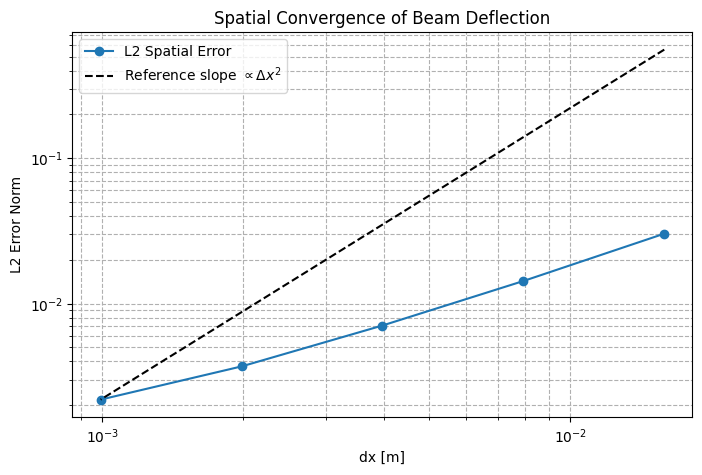

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def run_simulation(N):
    dx = L / (N - 1)
    x = np.linspace(0, L, N)
    time_steps = int(T_final / dt) + 1

    # Redefine D4 matrix
    main = -6 * np.ones(N)
    off1 = 4 * np.ones(N - 1)
    off2 = -1 * np.ones(N - 2)
    D4 = diags([off2, off1, main, off1, off2], [-2, -1, 0, 1, 2]).toarray() / dx**4
    D4[0, :] = D4[1, :] = D4[-2, :] = D4[-1, :] = 0

    def Cl_from_alpha(alpha_deg):
        return 0.11 * alpha_deg + 0.2

    def alpha_approx(max_deflection_deg=30, min_deflection_deg=-30, frequency_hz=ELEVATOR_FREQ_HZ,
                     chord_stab_in=6.0, chord_elev_in=3.25, t_final=T_final, dt=dt):
        chord_stab = chord_stab_in * 0.0254
        chord_elev = chord_elev_in * 0.0254
        t = np.linspace(0, t_final, int(t_final / dt) + 1)
        amplitude = (max_deflection_deg - min_deflection_deg) / 2
        mean_angle = (max_deflection_deg + min_deflection_deg) / 2
        elevator_deflection = mean_angle + amplitude * np.sin(2 * np.pi * frequency_hz * t)
        delta_rad = np.deg2rad(elevator_deflection)
        elev_x = chord_elev * np.cos(delta_rad)
        elev_y = chord_elev * np.sin(delta_rad)
        alpha_eff_rad = np.arctan2(elev_y, chord_stab + elev_x)
        alpha_eff_deg = np.rad2deg(alpha_eff_rad)
        return t, alpha_eff_deg, elevator_deflection

    def lift_force(V=90):
        rho_air = 1.225
        chord_hstab = 9.25 * 0.0254
        V_mps = V * 0.3048
        t_vals, alpha_eff_deg, _ = alpha_approx()
        Cl_vals = Cl_from_alpha(alpha_eff_deg)
        L_per_m = 0.5 * rho_air * V_mps**2 * Cl_vals * chord_hstab
        return np.tile(L_per_m, (N, 1)), t_vals

    f_force, _ = lift_force(V=90)

    # Initialize solution arrays
    u = np.zeros((N, time_steps))
    u_prev = np.zeros(N)

    r = (EI_total / rhoA_total) * dt**2 / (2 * dx**4)

    for n in range(1, time_steps):
        rhs = (
            2 * u[:, n - 1]
            - u_prev
            + dt**2 * (0.5 * (f_force[:, n - 1] + f_force[:, n])) / rhoA_total
            - r * D4 @ u_prev
        )
        rhs[0] = rhs[1] = 0
        u_next = spsolve(np.eye(N) + r * D4, rhs)
        u_prev = u[:, n - 1]
        u[:, n] = u_next

    return x, u[:, -1]

# === Convergence Study ===
Ns = [21, 41, 81, 161, 321]
ref_N = 1281
x_ref, u_ref = run_simulation(ref_N)

errors = []
dxs = []

for N in Ns:
    x_coarse, u_coarse = run_simulation(N)
    interp_ref = interp1d(x_ref, u_ref, kind='cubic')
    u_ref_interp = interp_ref(x_coarse)
    dx = L / (N - 1)
    dxs.append(dx)
    error = np.sqrt(np.sum((u_coarse - u_ref_interp)**2) * dx)
    errors.append(error)

# === Plotting ===
plt.figure(figsize=(8, 5))
plt.loglog(dxs, errors, 'o-', label='L2 Spatial Error')

# Reference line for 2nd-order convergence
ref_slope = 2
ref_dx = dxs[-1]  # Use the finest resolution for placement
ref_err = errors[-1]
ref_line = ref_err * (np.array(dxs) / ref_dx) ** ref_slope
plt.loglog(dxs, ref_line, 'k--', label=r'Reference slope $\propto \Delta x^2$')

plt.xlabel("dx [m]")
plt.ylabel("L2 Error Norm")
plt.grid(True, which="both", ls="--")
plt.title("Spatial Convergence of Beam Deflection")
plt.legend()
plt.show()


# Temporal Convergence Test

<ipython-input-21-cac4a4428e2a>:64: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_next = spsolve(np.eye(N) + r * D4, rhs)


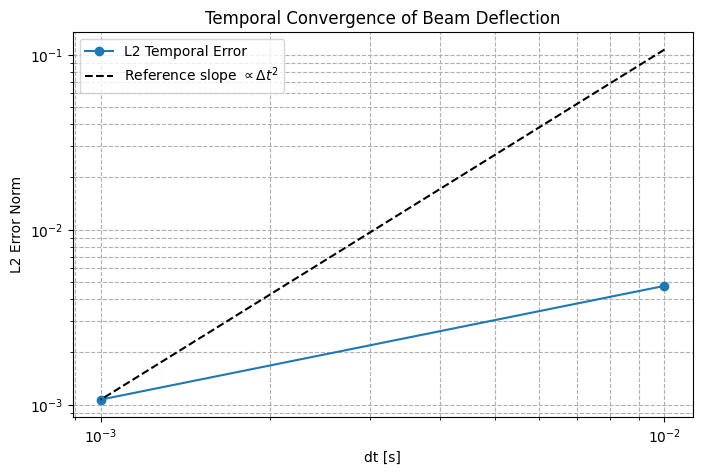

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def run_simulation(N, dt_local):
    dx = L / (N - 1)
    x = np.linspace(0, L, N)
    time_steps = int(T_final / dt_local) + 1

    # Build fourth derivative matrix D4
    main = -6 * np.ones(N)
    off1 = 4 * np.ones(N - 1)
    off2 = -1 * np.ones(N - 2)
    D4 = diags([off2, off1, main, off1, off2], [-2, -1, 0, 1, 2]).toarray() / dx**4
    D4[0, :] = D4[1, :] = D4[-2, :] = D4[-1, :] = 0

    # Lift forcing
    def Cl_from_alpha(alpha_deg):
        return 0.11 * alpha_deg + 0.2

    def alpha_approx(max_deflection_deg=30, min_deflection_deg=-30, frequency_hz=ELEVATOR_FREQ_HZ,
                     chord_stab_in=6.0, chord_elev_in=3.25, t_final=T_final, dt=dt_local):
        chord_stab = chord_stab_in * 0.0254
        chord_elev = chord_elev_in * 0.0254
        t = np.linspace(0, t_final, int(t_final / dt) + 1)
        amplitude = (max_deflection_deg - min_deflection_deg) / 2
        mean_angle = (max_deflection_deg + min_deflection_deg) / 2
        elevator_deflection = mean_angle + amplitude * np.sin(2 * np.pi * frequency_hz * t)
        delta_rad = np.deg2rad(elevator_deflection)
        elev_x = chord_elev * np.cos(delta_rad)
        elev_y = chord_elev * np.sin(delta_rad)
        alpha_eff_rad = np.arctan2(elev_y, chord_stab + elev_x)
        alpha_eff_deg = np.rad2deg(alpha_eff_rad)
        return t, alpha_eff_deg, elevator_deflection

    def lift_force(V=90):
        rho_air = 1.225
        chord_hstab = 9.25 * 0.0254
        V_mps = V * 0.3048
        t_vals, alpha_eff_deg, _ = alpha_approx()
        Cl_vals = Cl_from_alpha(alpha_eff_deg)
        L_per_m = 0.5 * rho_air * V_mps**2 * Cl_vals * chord_hstab
        return np.tile(L_per_m, (N, 1))

    f_force = lift_force(V=90)

    # Crank–Nicolson scheme
    alpha = EI_total / rhoA_total
    r = alpha * dt_local**2 / (2 * dx**4)

    u = np.zeros((N, time_steps))
    u_prev = np.zeros(N)

    for n in range(1, time_steps):
        rhs = (
            2 * u[:, n - 1]
            - u_prev
            + dt_local**2 * (0.5 * (f_force[:, n - 1] + f_force[:, n])) / rhoA_total
            - r * D4 @ u_prev
        )
        rhs[0] = rhs[1] = 0
        u_next = spsolve(np.eye(N) + r * D4, rhs)
        u_prev = u[:, n - 1]
        u[:, n] = u_next

    return x, u[:, -1]

# === Temporal Convergence Study ===
N_fixed = 1000
dts = [0.01, 0.001, 0.0001]
x_ref, u_ref = run_simulation(N_fixed, dts[-1])  # Reference at finest dt
errors_t = []

for dt_val in dts[:-1]:
    x_test, u_test = run_simulation(N_fixed, dt_val)
    error = np.sqrt(np.sum((u_test - u_ref)**2) * (L / (N_fixed - 1)))
    errors_t.append(error)

# === Plot Temporal Convergence ===
plt.figure(figsize=(8, 5))
plt.loglog(dts[:-1], errors_t, 'o-', label='L2 Temporal Error')

# Reference line for 2nd-order convergence
ref_slope = 2
ref_dt = dts[-2]  # second smallest dt (not the reference one)
ref_err = errors_t[-1]  # smallest error
ref_line = ref_err * (np.array(dts[:-1]) / ref_dt)**ref_slope
plt.loglog(dts[:-1], ref_line, 'k--', label=r'Reference slope $\propto \Delta t^2$')

plt.xlabel("dt [s]")
plt.ylabel("L2 Error Norm")
plt.grid(True, which="both", ls="--")
plt.title("Temporal Convergence of Beam Deflection")
plt.legend()
plt.show()

# Stability Plots

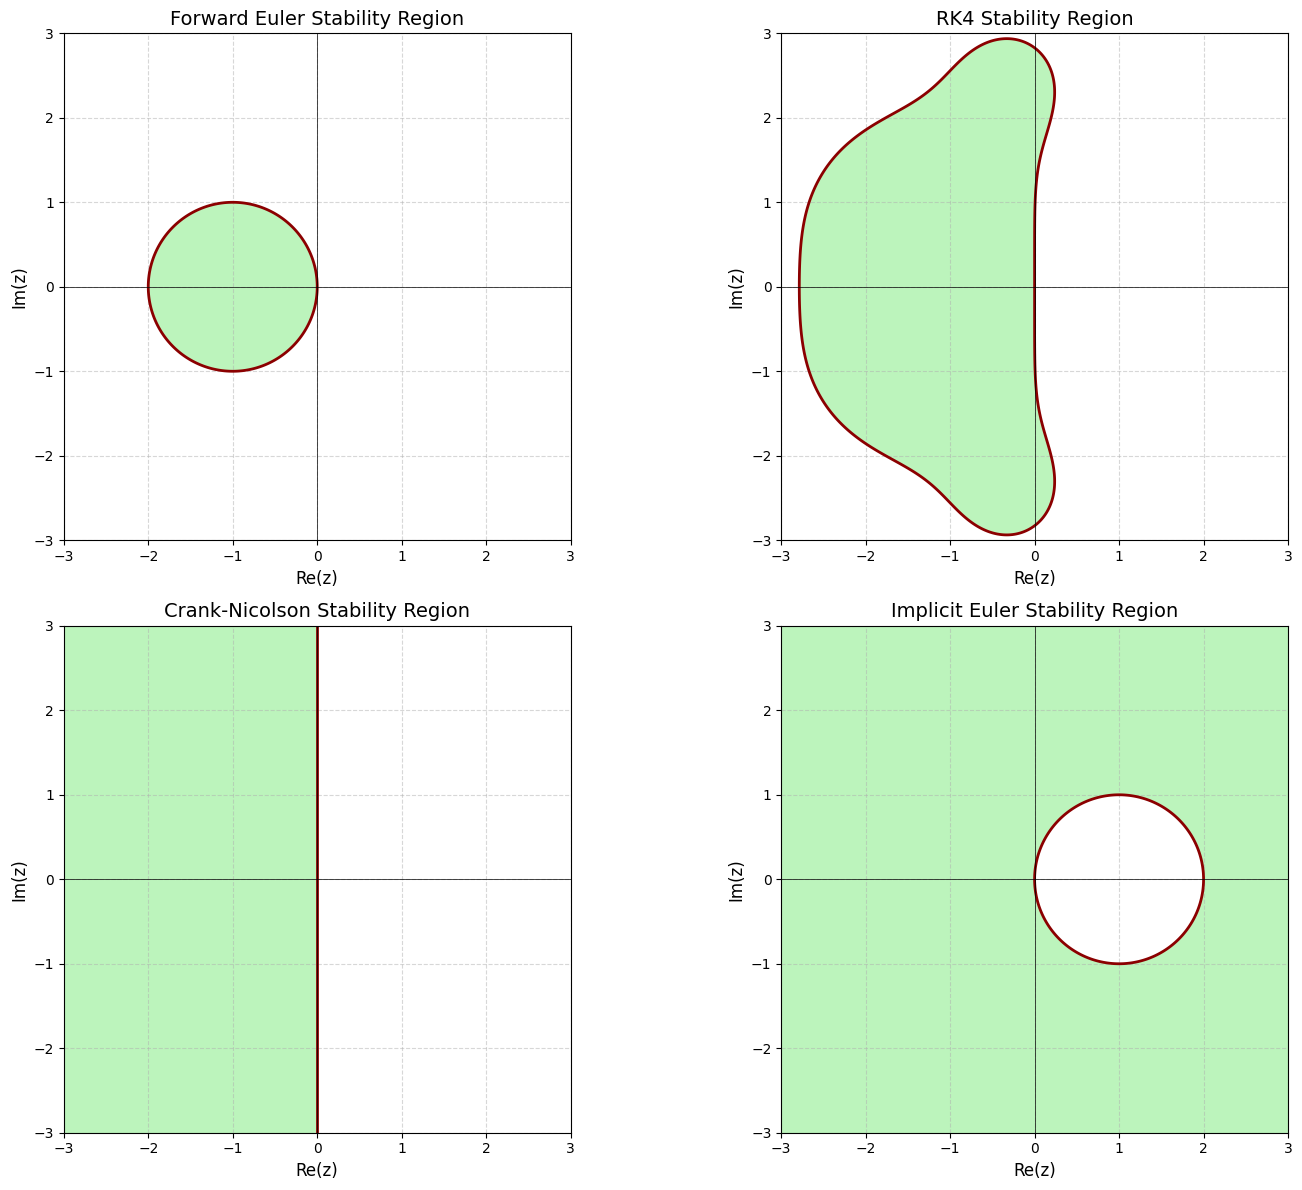

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define stability functions for each method
def forward_euler_stability(z):
    return np.abs(1 + z)  # R(z) = 1 + z

def rk4_stability(z):
    return np.abs(1 + z + z**2/2 + z**3/6 + z**4/24)  # R(z) = 1 + z + z²/2 + z³/6 + z⁴/24

def crank_nicolson_stability(z):
    return np.abs((1 + z/2) / (1 - z/2))  # R(z) = (1 + z/2)/(1 - z/2)

def implicit_euler_stability(z):
    return np.abs(1 / (1 - z))  # R(z) = 1/(1 - z)

# Create a grid of complex numbers (z = Δt * λ)
real_vals = np.linspace(-3, 3, 500)
imag_vals = np.linspace(-3, 3, 500)
real_grid, imag_grid = np.meshgrid(real_vals, imag_vals)
z_grid = real_grid + 1j * imag_grid

# Compute stability regions
R_forward_euler = forward_euler_stability(z_grid)
R_rk4 = rk4_stability(z_grid)
R_crank_nicolson = crank_nicolson_stability(z_grid)
R_implicit_euler = implicit_euler_stability(z_grid)

# Plot settings
plt.figure(figsize=(15, 12))

# Forward Euler
plt.subplot(2, 2, 1)
plt.contourf(real_grid, imag_grid, R_forward_euler, levels=[0, 1], colors='lightgreen', alpha=0.6)
plt.contour(real_grid, imag_grid, R_forward_euler, levels=[1], colors='darkred', linewidths=2)
plt.title("Forward Euler Stability Region", fontsize=14)
plt.xlabel('Re(z)', fontsize=12)
plt.ylabel('Im(z)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal')

# RK4
plt.subplot(2, 2, 2)
plt.contourf(real_grid, imag_grid, R_rk4, levels=[0, 1], colors='lightgreen', alpha=0.6)
plt.contour(real_grid, imag_grid, R_rk4, levels=[1], colors='darkred', linewidths=2)
plt.title("RK4 Stability Region", fontsize=14)
plt.xlabel('Re(z)', fontsize=12)
plt.ylabel('Im(z)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal')

# Crank-Nicolson
plt.subplot(2, 2, 3)
plt.contourf(real_grid, imag_grid, R_crank_nicolson, levels=[0, 1], colors='lightgreen', alpha=0.6)
plt.contour(real_grid, imag_grid, R_crank_nicolson, levels=[1], colors='darkred', linewidths=2)
plt.title("Crank-Nicolson Stability Region", fontsize=14)
plt.xlabel('Re(z)', fontsize=12)
plt.ylabel('Im(z)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal')

# Implicit Euler
plt.subplot(2, 2, 4)
plt.contourf(real_grid, imag_grid, R_implicit_euler, levels=[0, 1], colors='lightgreen', alpha=0.6)
plt.contour(real_grid, imag_grid, R_implicit_euler, levels=[1], colors='darkred', linewidths=2)
plt.title("Implicit Euler Stability Region", fontsize=14)
plt.xlabel('Re(z)', fontsize=12)
plt.ylabel('Im(z)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

# Incorrect Version

<ipython-input-2-ff79f6069ed0>:198: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_next = spsolve(np.eye(N) + r * D4, rhs)


t = 0.0100 s, Lift = 150.868 N/m
t = 0.0200 s, Lift = -58.606 N/m
t = 0.0300 s, Lift = -58.606 N/m
t = 0.0400 s, Lift = 150.868 N/m
t = 0.0500 s, Lift = 21.658 N/m
t = 0.0600 s, Lift = -107.551 N/m
t = 0.0700 s, Lift = 101.923 N/m
t = 0.0800 s, Lift = 101.923 N/m
t = 0.0900 s, Lift = -107.551 N/m
t = 0.1000 s, Lift = 21.658 N/m
t = 0.1100 s, Lift = 150.868 N/m
t = 0.1200 s, Lift = -58.606 N/m
t = 0.1300 s, Lift = -58.606 N/m
t = 0.1400 s, Lift = 150.868 N/m
t = 0.1500 s, Lift = 21.658 N/m
t = 0.1600 s, Lift = -107.551 N/m
t = 0.1700 s, Lift = 101.923 N/m
t = 0.1800 s, Lift = 101.923 N/m
t = 0.1900 s, Lift = -107.551 N/m
t = 0.2000 s, Lift = 21.658 N/m
t = 0.2100 s, Lift = 150.868 N/m
t = 0.2200 s, Lift = -58.606 N/m
t = 0.2300 s, Lift = -58.606 N/m
t = 0.2400 s, Lift = 150.868 N/m
t = 0.2500 s, Lift = 21.658 N/m
t = 0.2600 s, Lift = -107.551 N/m
t = 0.2700 s, Lift = 101.923 N/m
t = 0.2800 s, Lift = 101.923 N/m
t = 0.2900 s, Lift = -107.551 N/m
t = 0.3000 s, Lift = 21.658 N/m
t = 0.3100

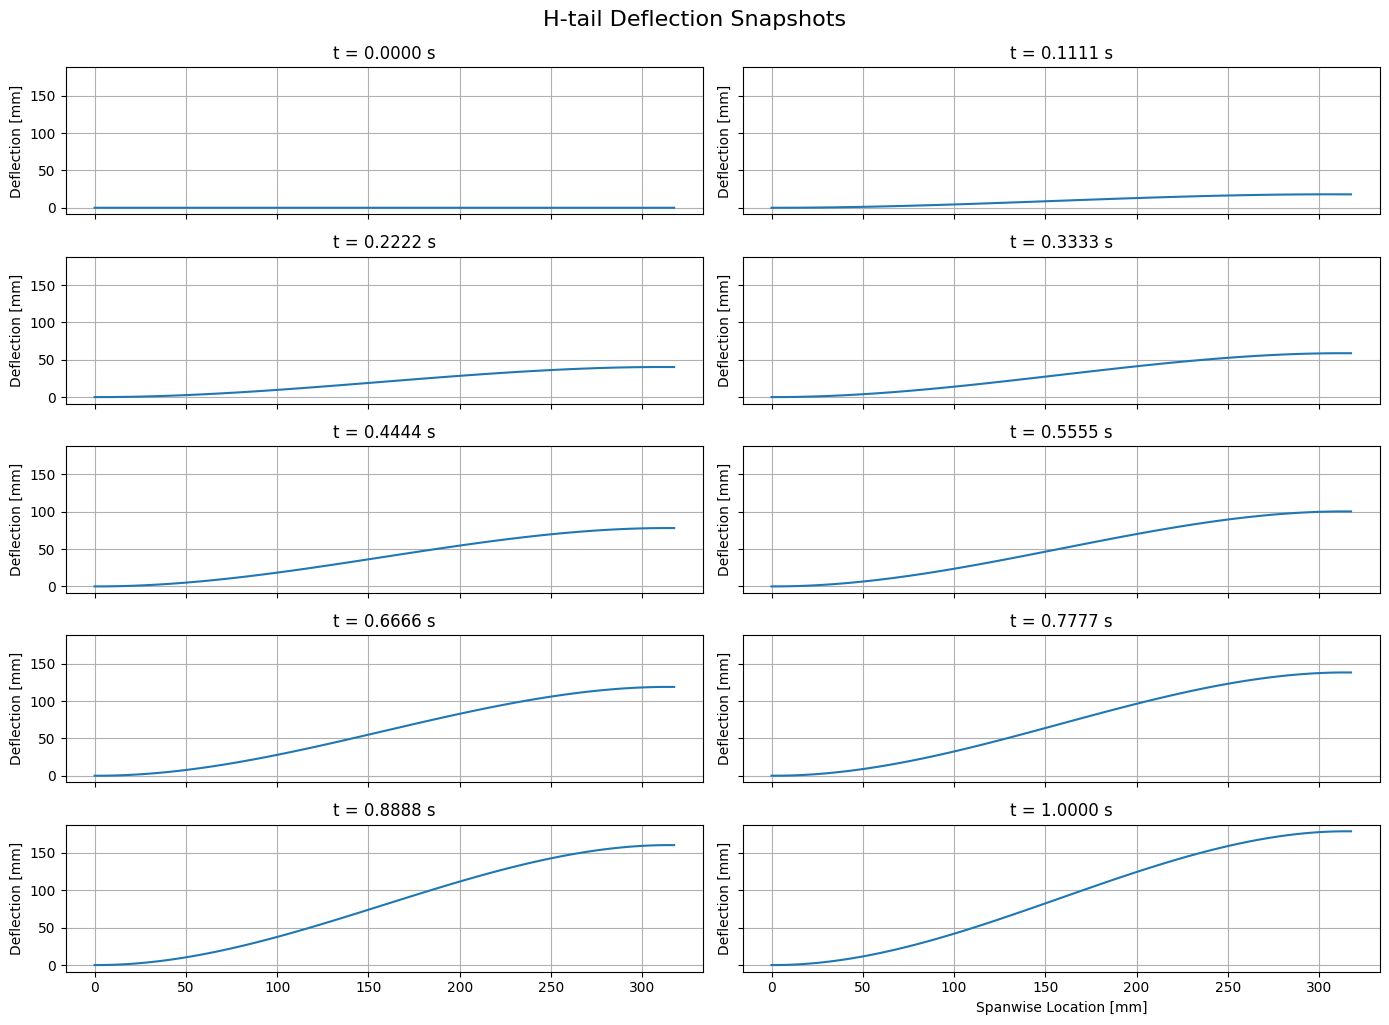

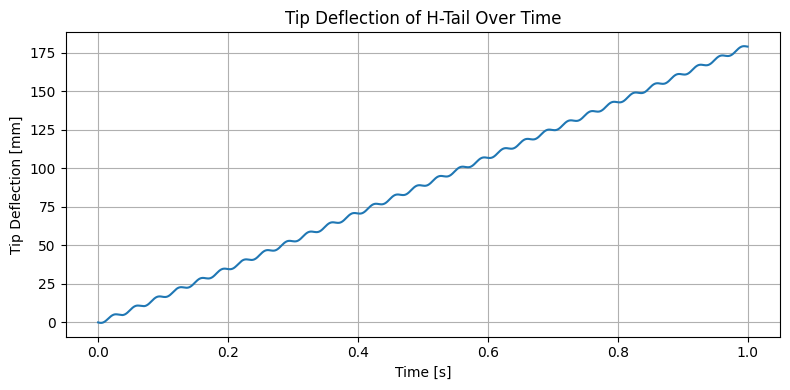

2.2444835258496308e-07


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Geometry (converted from inches to meters) ===
span_in = 12.5               # H-tail span [in]
chord_in = 9.25              # Chord length [in]
thickness_in = chord_in * 0.16          # Airfoil thickness [in]
t_plywood = 0.0937 * 0.0254             # Plywood thickness [m]

# Spar positions (aft of leading edge)
spar1_pos_in = 1.13
spar2_pos_in = 5.55

# Convert to meters
L = span_in * 0.0254
spar1_pos = spar1_pos_in * 0.0254
spar2_pos = spar2_pos_in * 0.0254

# === Spar Dimensions ===
b_spar1 = 12.5 * 0.0254
h_spar1 = 0.9 * 0.0254
b_spar2 = 12.3 * 0.0254
h_spar2 = 0.6 * 0.0254

def hollow_box_I(b, h, t):
    return (b * h**3 - (b - 2*t)*(h - 2*t)**3) / 12

def hollow_box_A(b, h, t):
    return 2 * t * (b + h)

# === Material Properties ===
E = 9e9               # Plywood [Pa]
rho_s = 832           # Plywood [kg/m^3]
E_cf = 140e9          # Carbon Fiber [Pa]
rho_cf = 1930         # Carbon Fiber [kg/m^3]
r_cf = 0.1425 * 0.0254  # Shaft radius [m]


# === Compute Effective Stiffness and Mass ===
# Plywood contribution
I_ply = hollow_box_I(b_spar1, h_spar1, t_plywood) + hollow_box_I(b_spar2, h_spar2, t_plywood)
A_ply = hollow_box_A(b_spar1, h_spar1, t_plywood) + hollow_box_A(b_spar2, h_spar2, t_plywood)

# Carbon fiber shafts
I_cf = 2 * (np.pi * r_cf**4 / 4)
A_cf = 2 * (np.pi * r_cf**2)

# Combined properties
EI_total = E * I_ply + E_cf * I_cf
rhoA_total = rho_s * A_ply + rho_cf * A_cf

# Damping coefficients
re_external = 120       # aerodynamic damping (kg/m·s)

ELEVATOR_FREQ_HZ = 30

# === Simulation Parameters ===
dt = 0.0001         # time step (s)
T_final = 1       # simulation duration (s)
N = 101              # spatial points
dx = L / (N - 1)
x = np.linspace(0, L, N)
time_steps = int(T_final / dt) + 1

# === Get aerodynamic forcing from elevator motion ===
def Cl_from_alpha(alpha_deg):
    m = 0.12
    b = 0.2
    return m * alpha_deg + b

def alpha_approx(
    max_deflection_deg=30,
    min_deflection_deg=-30,
    frequency_hz=ELEVATOR_FREQ_HZ,
    chord_stab_in=6.0,
    chord_elev_in=3.25,
    t_final=0.1,
    dt=0.0001,
    plot=False
):
    chord_stab = chord_stab_in * 0.0254
    chord_elev = chord_elev_in * 0.0254
    t = np.linspace(0, t_final, int(t_final / dt) + 1)
    amplitude = (max_deflection_deg - min_deflection_deg) / 2
    mean_angle = (max_deflection_deg + min_deflection_deg) / 2
    elevator_deflection = mean_angle + amplitude * np.sin(2 * np.pi * frequency_hz * t)
    delta_rad = np.deg2rad(elevator_deflection)
    elev_x = chord_elev * np.cos(delta_rad)
    elev_y = chord_elev * np.sin(delta_rad)
    alpha_eff_rad = np.arctan2(elev_y, chord_stab + elev_x)
    alpha_eff_deg = np.rad2deg(alpha_eff_rad)
    return t, alpha_eff_deg, elevator_deflection

def lift_force(V=90, plot=False, plot_force=False):
    rho_air = 1.225
    chord_hstab_in = 9.25
    chord_hstab = chord_hstab_in * 0.0254
    V_mps = V * 0.3048

    t, alpha_eff_deg, _ = alpha_approx(
        max_deflection_deg=30,
        min_deflection_deg=-30,
        frequency_hz=ELEVATOR_FREQ_HZ,
        chord_stab_in=6.0,
        chord_elev_in=3.25,
        t_final=T_final,
        dt=dt,
        plot=False
    )

    Cl_vals = Cl_from_alpha(alpha_eff_deg)
    L_per_m = 0.5 * rho_air * V_mps**2 * Cl_vals * chord_hstab

    f_force = np.tile(L_per_m, (N, 1))

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(t, Cl_vals)
        plt.xlabel("Time [s]")
        plt.ylabel("Lift Coefficient Cl")
        plt.grid(True)
        plt.title("Lift Coefficient Over Time")
        plt.tight_layout()
        plt.show()

    if plot_force:
        plt.figure(figsize=(10, 4))
        plt.plot(t, f_force[-1, :])
        plt.xlabel("Time [s]")
        plt.ylabel("Lift Force per Unit Span [N/m]")
        plt.title("Distributed Lift Force vs Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return f_force, t

# === Retrieve forcing input ===
f_force, t = lift_force(V=90)

# === Compute static displacement as initial condition ===

# Prepare average force over time (mean across time axis)
f_static = np.mean(f_force, axis=1).copy()
f_static[0] = 0
f_static[1] = 0
f_static[-2] = 0
f_static[-1] = 0

# === Crank-Nicolson Setup ===
alpha = (EI_total) / (rhoA_total)
r = alpha * dt**2 / (2 * dx**4)

# Build 4th derivative matrix (central difference)
main = -6 * np.ones(N)
off1 = 4 * np.ones(N - 1)
off2 = -1 * np.ones(N - 2)
D4 = diags([off2, off1, main, off1, off2], [-2, -1, 0, 1, 2]).toarray() / dx**4
D4[0, :] = D4[1, :] = D4[-2, :] = D4[-1, :] = 0

# Make a copy of D4 to modify safely
D4_static = D4.copy()

# Apply clamped-free BCs
D4_static[0, :] = 0; D4_static[0, 0] = 1
D4_static[1, :] = 0; D4_static[1, 0:3] = np.array([-3, 4, -1]) / (2 * dx)
D4_static[-2, :] = 0; D4_static[-2, -3:] = np.array([1, -2, 1]) / dx**2
D4_static[-1, :] = 0; D4_static[-1, -4:] = np.array([-1, 3, -3, 1]) / dx**3

# Solve for static displacement
w_static = np.linalg.solve(EI_total * D4_static, f_static)

# Initialize displacement arrays
u = np.zeros((N, time_steps))
u_prev = np.zeros(N)

# Set initial condition
u[:, 0] = w_static
v_initial = 90 * 0.3048  # example: 90 ft/s → m/s
u[:, 1] = u[:, 0] + dt * v_initial

# # Time integration with damping
for n in range(1, time_steps):
    u_dot = (u[:, n -1] - u_prev) / dt

    damping_ext = re_external * u_dot

    rhs = (
        2 * u[:, n -1]
        - u_prev
        + dt**2 * (0.5 * (f_force[:, n -1] + f_force[:, n]) - damping_ext) / rhoA_total
        - r * D4 @ u_prev
    )
    rhs[0] = rhs[1] = 0

    u_next = spsolve(np.eye(N) + r * D4, rhs)

    u_prev = u[:, n -1]
    u[:, n] = u_next

    if n % int(0.01 / dt) ==0:
        print(f"t = {t[n]:.4f} s, Lift = {f_force[-1, n]:.3f} N/m")


# === Plot 1: Deflection snapshots ===
plot_count = 10
indices = np.linspace(0, time_steps - 1, plot_count, dtype=int)
fig, axes = plt.subplots(5, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].plot(x * 1000, u[:, idx] * 1000)
    axes[i].set_title(f"t = {t[idx]:.4f} s")
    axes[i].set_ylabel("Deflection [mm]")
    axes[i].grid(True)
axes[-1].set_xlabel("Spanwise Location [mm]")
plt.tight_layout()
plt.suptitle("H-tail Deflection Snapshots", fontsize=16, y=1.02)
plt.show()

# === Plot 2: Tip deflection vs time ===
plt.figure(figsize=(8, 4))
plt.plot(t, u[-1, :] * 1000)
plt.xlabel("Time [s]")
plt.ylabel("Tip Deflection [mm]")
plt.title("Tip Deflection of H-Tail Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

print(I_ply+I_cf)